In [1]:
from minisom import MiniSom
from pathlib import Path
# from rastertools import download, raster_clip, utils
import numpy as np
import rasterio
import os
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans

# Import Data

In [2]:
grid3_gdf = gpd.read_file('datasets\\NGA_population_v2_0_admin\\GRID3_NGA_population_v2_0_admin_LGA.shp')
grid3_gdf = grid3_gdf.to_crs(epsg=3395)
grid3_gdf["log_pop"] = np.log10(grid3_gdf["mean"]+1)
grid3_gdf["lga_area"] = grid3_gdf["geometry"].area
grid3_gdf["pop_density"] = (grid3_gdf["mean"]+1)/grid3_gdf["lga_area"]
grid3_gdf["log_pop_density"] = np.log10(grid3_gdf["pop_density"])
grid3_gdf.head(2)

,lga_code,id,state_code,source,lga_name_x,amap_code,global_id,lga_name_y,mean,q50,q025,q975,geometry,log_pop,lga_area,pop_density,log_pop_density
0,10001,u_boundary_lgas.153,DE,WHO,Aniocha North,NIE DTS SLK,350372be-15df-46fc-b84e-6dfa8453b81a,Aniocha North,91927.4488,91495.5,77438.350,109182.025,"POLYGON ((716692.192 693135.210, 715976.463 69...",4.96345,4.110072e+08,0.000224,-3.650399
1,10002,u_boundary_lgas.83,DE,WHO,Aniocha South,NIE DTS GWK,1e1140ab-a4f7-41f4-a237-0f712dd61afa,Aniocha South,193913.2723,192924.5,162260.375,231135.225,"POLYGON ((722034.058 663499.764, 721256.035 66...",5.28761,8.773403e+08,0.000221,-3.655558


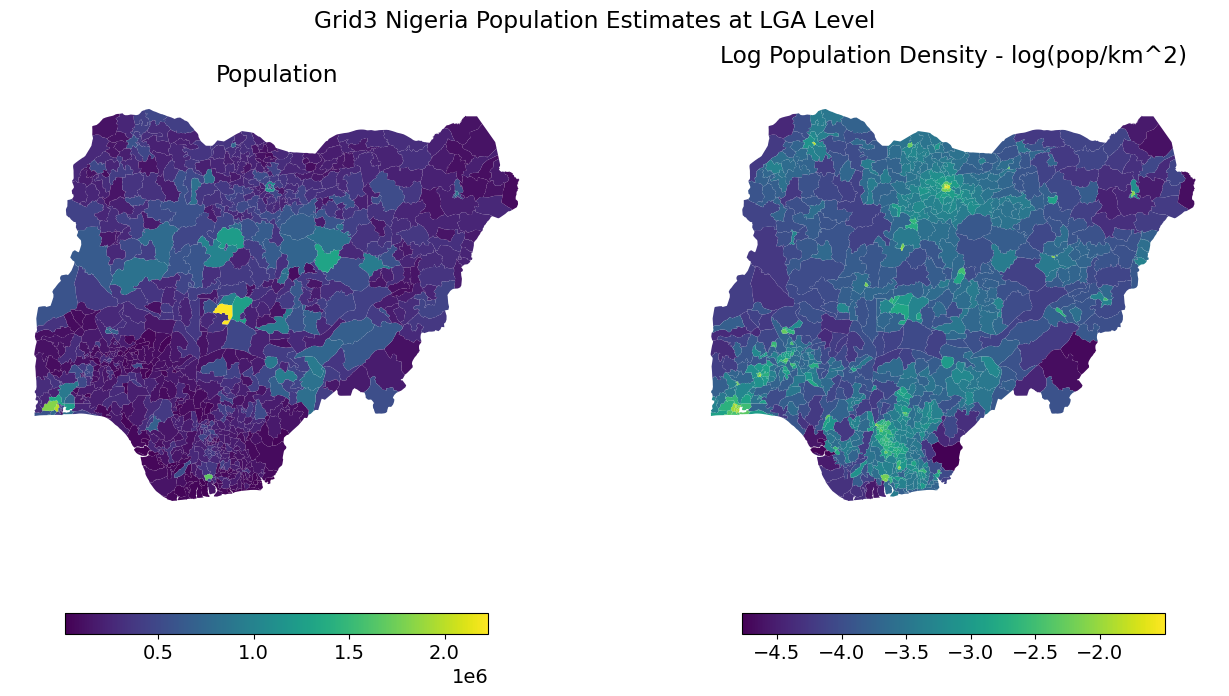

In [5]:
plt.rc('font', size=14) 

fig, axs = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('Grid3 Nigeria Population Estimates at LGA Level')
grid3_gdf.plot("mean", ax=axs[0], legend=True, legend_kwds={
        "location":"bottom",
        "shrink":.75
    })
axs[0].set_title("Population")
axs[0].axis('off')
grid3_gdf.plot("log_pop_density", ax=axs[1], legend=True, legend_kwds={
        "location":"bottom",
        "shrink":.75
    })
axs[1].set_title("Log Population Density - log(pop/km^2)")
axs[1].axis('off')

plt.show()

In [7]:
landcover_gdf = gpd.read_file("datasets/geonetwork_landcover_nga_gc_adg.zip")
landcover_gdf = landcover_gdf.to_crs(epsg=3395)
landcover_gdf['landcover_area']=landcover_gdf['geometry'].area
landcover_gdf.head()

,AREA_M2,ID,GRIDCODE,LCCCode,geometry,landcover_area
0,1095568.0,1,14,11498,"POLYGON ((614498.260 1551379.937, 615208.518 1...",1.162085e+06
1,2755938.0,2,150,20049 // 20058,"POLYGON ((612102.589 1550113.867, 612102.589 1...",2.923144e+06
2,369093.0,3,200,0011,"POLYGON ((614885.576 1551063.414, 615194.797 1...",3.914954e+05
3,1939338.0,4,150,20049 // 20058,"POLYGON ((616431.680 1550746.894, 616431.680 1...",2.056920e+06
4,7145306.0,5,20,0003 / 0004,"POLYGON ((615194.797 1550113.867, 615504.018 1...",7.577852e+06


(230192.00435510487, 1701034.713970979, 419478.3945771495, 1605486.4231043654)

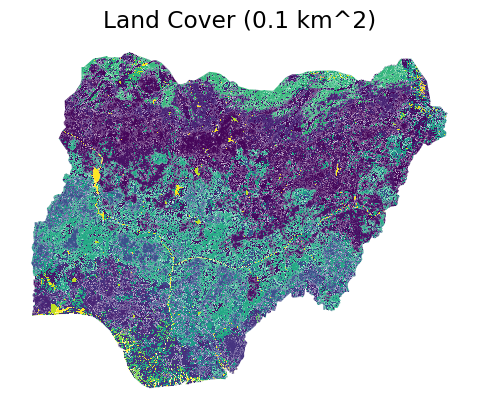

In [9]:
landcover_gdf.plot("GRIDCODE")
plt.title("Land Cover (0.1 km^2)")
plt.axis('off')

# Combine Landcover and Population Data

In [10]:
# Check that both are in the same coordinate system
assert landcover_gdf.crs == grid3_gdf.crs, "GeoDataFrames have different crs"

# Spatially join
joined_gdf = gpd.sjoin(landcover_gdf, grid3_gdf, how="inner", op='intersects')

c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [11]:
aggregated_gdf = joined_gdf.groupby(['lga_name_x', 'GRIDCODE'])['landcover_area'].sum().reset_index(name='total_area')

aggregated_gdf['percentage'] = aggregated_gdf.apply(lambda row: (row['total_area'] / grid3_gdf.loc[grid3_gdf['lga_name_x'] == row['lga_name_x'], 'lga_area'].values[0]) * 100, axis=1)

In [12]:
# Pivot the DataFrame to have 'GRIDCODE' as columns, with percentages as values
pivot_df = aggregated_gdf.pivot(index='lga_name_x', columns='GRIDCODE', values='percentage').reset_index()
pivot_df.fillna(0, inplace=True)
pivot_df.columns = ['landcover_' + str(col) if isinstance(col, int) else col for col in pivot_df.columns]

# Merge the pivot_df back into grid3_gdf to get the final DataFrame
combined_data_gdf = pd.merge(grid3_gdf, pivot_df, on='lga_name_x', how='left')
combined_data_gdf.drop(columns=['amap_code', 'global_id', 'lga_name_y','source'], inplace=True)
combined_data_gdf.rename(columns={"lga_name_x":"lga_name", "mean":"mean_pop"}, inplace=True)


In [13]:
combined_data_gdf.head()

,lga_code,id,state_code,lga_name,mean_pop,q50,q025,q975,geometry,log_pop,...,landcover_143,landcover_150,landcover_160,landcover_170,landcover_180,landcover_190,landcover_200,landcover_201,landcover_202,landcover_210
0,10001,u_boundary_lgas.153,DE,Aniocha North,91927.4488,91495.5,77438.350,109182.025,"POLYGON ((716692.192 693135.210, 715976.463 69...",4.963450,...,0.0,0.0,2.929248,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,10002,u_boundary_lgas.83,DE,Aniocha South,193913.2723,192924.5,162260.375,231135.225,"POLYGON ((722034.058 663499.764, 721256.035 66...",5.287610,...,0.0,0.0,29.147800,0.000000,0.0,0.0,0.0,0.0,0.0,0.043549
2,10003,u_boundary_lgas.668,DE,Bomadi,32604.4158,32464.0,27605.925,38545.150,"POLYGON ((646456.016 574401.078, 645696.550 57...",4.513290,...,0.0,0.0,32.602198,0.000000,0.0,0.0,0.0,0.0,0.0,19.970442
3,10004,u_boundary_lgas.70,DE,Burutu,53159.2710,52898.0,44870.700,62668.150,"MULTIPOLYGON (((595539.795 602125.507, 597576....",4.725587,...,0.0,0.0,15.399030,2.090292,0.0,0.0,0.0,0.0,0.0,15.255538
4,10005,u_boundary_lgas.418,DE,Ethiope East,153016.5149,152455.5,130269.600,180092.075,"POLYGON ((674484.483 623635.233, 674424.014 62...",5.184741,...,0.0,0.0,2.894418,1.819525,0.0,0.0,0.0,0.0,0.0,0.000000


In [14]:
combined_data_gdf.columns

Index(['lga_code', 'id', 'state_code', 'lga_name', 'mean_pop', 'q50', 'q025',
       'q975', 'geometry', 'log_pop', 'lga_area', 'pop_density',
       'log_pop_density', 'landcover_11', 'landcover_14', 'landcover_20',
       'landcover_30', 'landcover_32', 'landcover_40', 'landcover_41',
       'landcover_60', 'landcover_110', 'landcover_120', 'landcover_130',
       'landcover_134', 'landcover_140', 'landcover_141', 'landcover_143',
       'landcover_150', 'landcover_160', 'landcover_170', 'landcover_180',
       'landcover_190', 'landcover_200', 'landcover_201', 'landcover_202',
       'landcover_210'],
      dtype='object')

In [15]:
combined_data_gdf.to_file("example_data/lga_pop_landcover.shp")

C:\Users\soniaji\AppData\Local\Temp\ipykernel_18972\4028329932.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  combined_data_gdf.to_file("example_data/lga_pop_landcover.shp")


# SOM

In [34]:
features = combined_data_gdf[['log_pop_density', 'landcover_11',
       'landcover_14', 'landcover_20', 'landcover_30', 'landcover_32',
       'landcover_40', 'landcover_41', 'landcover_60', 'landcover_110',
       'landcover_120', 'landcover_130', 'landcover_134', 'landcover_140',
       'landcover_141', 'landcover_143', 'landcover_150', 'landcover_160',
       'landcover_170', 'landcover_180', 'landcover_190', 'landcover_200',
       'landcover_201', 'landcover_202', 'landcover_210']].values.astype(np.float64)
features.shape

(774, 25)

In [35]:
x, y = 10, 10

# Initialize the SOM
grid3_som = MiniSom(x, y, input_len=25, sigma=1.0, learning_rate=0.5)

# Train the SOM
grid3_som.train_random(features, 100)

In [36]:
grid3_som_weights = grid3_som.get_weights()
grid3_som_weights.shape

(10, 10, 25)

In [38]:
titles=["population", "Post-flooding or irrigated croplands", "Rainfed croplands",
'Mosaic cropland', 'Mosaic vegetation', 'Mosaic forest (50-70%)', 
'Closed to open (>15%) broadleaved evergreen or semi-deciduous forest (>5m)', 
'Closed (>40%) broadleaved evergreen and/or semi-deciduous forest (>5m)', 
'Open (15-40%) broadleaved deciduous forest/woodland (>5m)',
'Mosaic forest or shrubland (50-70%) / grassland', 'Mosaic grassland (50-70%) / forest or shrubland (20-50%)',
'Closed to open (>15%) (broadleaved or needleleaved, evergreen or deciduous) shrubland (<5m)',
'Closed to open (>15%) broadleaved deciduous shrubland (<5m)',
'Closed to open (>15%) herbaceous vegetation (grassland, savannas or lichens/mosses)',
'Closed (>40%) grassland', "143-unknown", 'Sparse (<15%) vegetation', 
'Closed to open (>15%) broadleaved forest regularly flooded (semi-permanently or temporarily) - Fresh or brackish water',
'Closed (>40%) broadleaved forest or shrubland permanently flooded - Saline or brackish water',
'Closed to open (>15%) grassland or woody vegetation on regularly flooded or waterlogged soil - Fresh, brackish or saline water',
'Artificial surfaces and associated areas (Urban areas >50%)',
'Bare areas', 'Consolidated bare areas (hardpans, gravels, bare rock, stones, boulders)',
'Non-consolidated bare areas (sandy desert)', 'Water bodies']

In [ ]:
fig, axs = plt.subplots(13, 2, figsize=(14, 42))
axs = axs.flatten()  # Flatten the array
fig.suptitle('SOM Weights By Feature')

# Use imshow to visualize the weights for each feature
for i in range(25):
    axs[i].imshow(grid3_som_weights[:, :, i], cmap='coolwarm', interpolation='none')
    axs[i].set_title(titles[i][:50])
    fig.colorbar(plt.cm.ScalarMappable(cmap='coolwarm'), ax=axs[i], label='weights')

# Show the plot
fig.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

# Clustering

In [40]:
grid3_weights_reshaped = np.reshape(grid3_som_weights, (x*y, 25))

kmeans5 = KMeans(n_clusters=5, random_state=0).fit(grid3_weights_reshaped)
kmeans10 = KMeans(n_clusters=10, random_state=0).fit(grid3_weights_reshaped)

c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_sta

In [41]:
winning_neurons = np.array([grid3_som.winner(feat) for feat in features])

# convert winning_neurons to a 1D array of integers for easy comparison with kmeans.labels_
winning_neurons_1d = np.ravel_multi_index(winning_neurons.T, (x, y))

# create a dictionary mapping from neuron index to cluster
neuron_to_cluster5 = dict(zip(range(x*y), kmeans5.labels_))
neuron_to_cluster10 = dict(zip(range(x*y), kmeans10.labels_))

# map each row to its corresponding cluster
combined_data_gdf['cluster_5'] = [neuron_to_cluster5[i] for i in winning_neurons_1d]
combined_data_gdf['cluster_10'] = [neuron_to_cluster10[i] for i in winning_neurons_1d]

In [45]:
combined_data_gdf["dominant_landcover"] = combined_data_gdf[
    ['landcover_11',
       'landcover_14', 'landcover_20', 'landcover_30', 'landcover_32',
       'landcover_40', 'landcover_41', 'landcover_60', 'landcover_110',
       'landcover_120', 'landcover_130', 'landcover_134', 'landcover_140',
       'landcover_141', 'landcover_143', 'landcover_150', 'landcover_160',
       'landcover_170', 'landcover_180', 'landcover_190', 'landcover_200',
       'landcover_201', 'landcover_202', 'landcover_210'
    ]].idxmax(axis=1)

Text(0.5, 1.0, 'Clusters (k=10)')

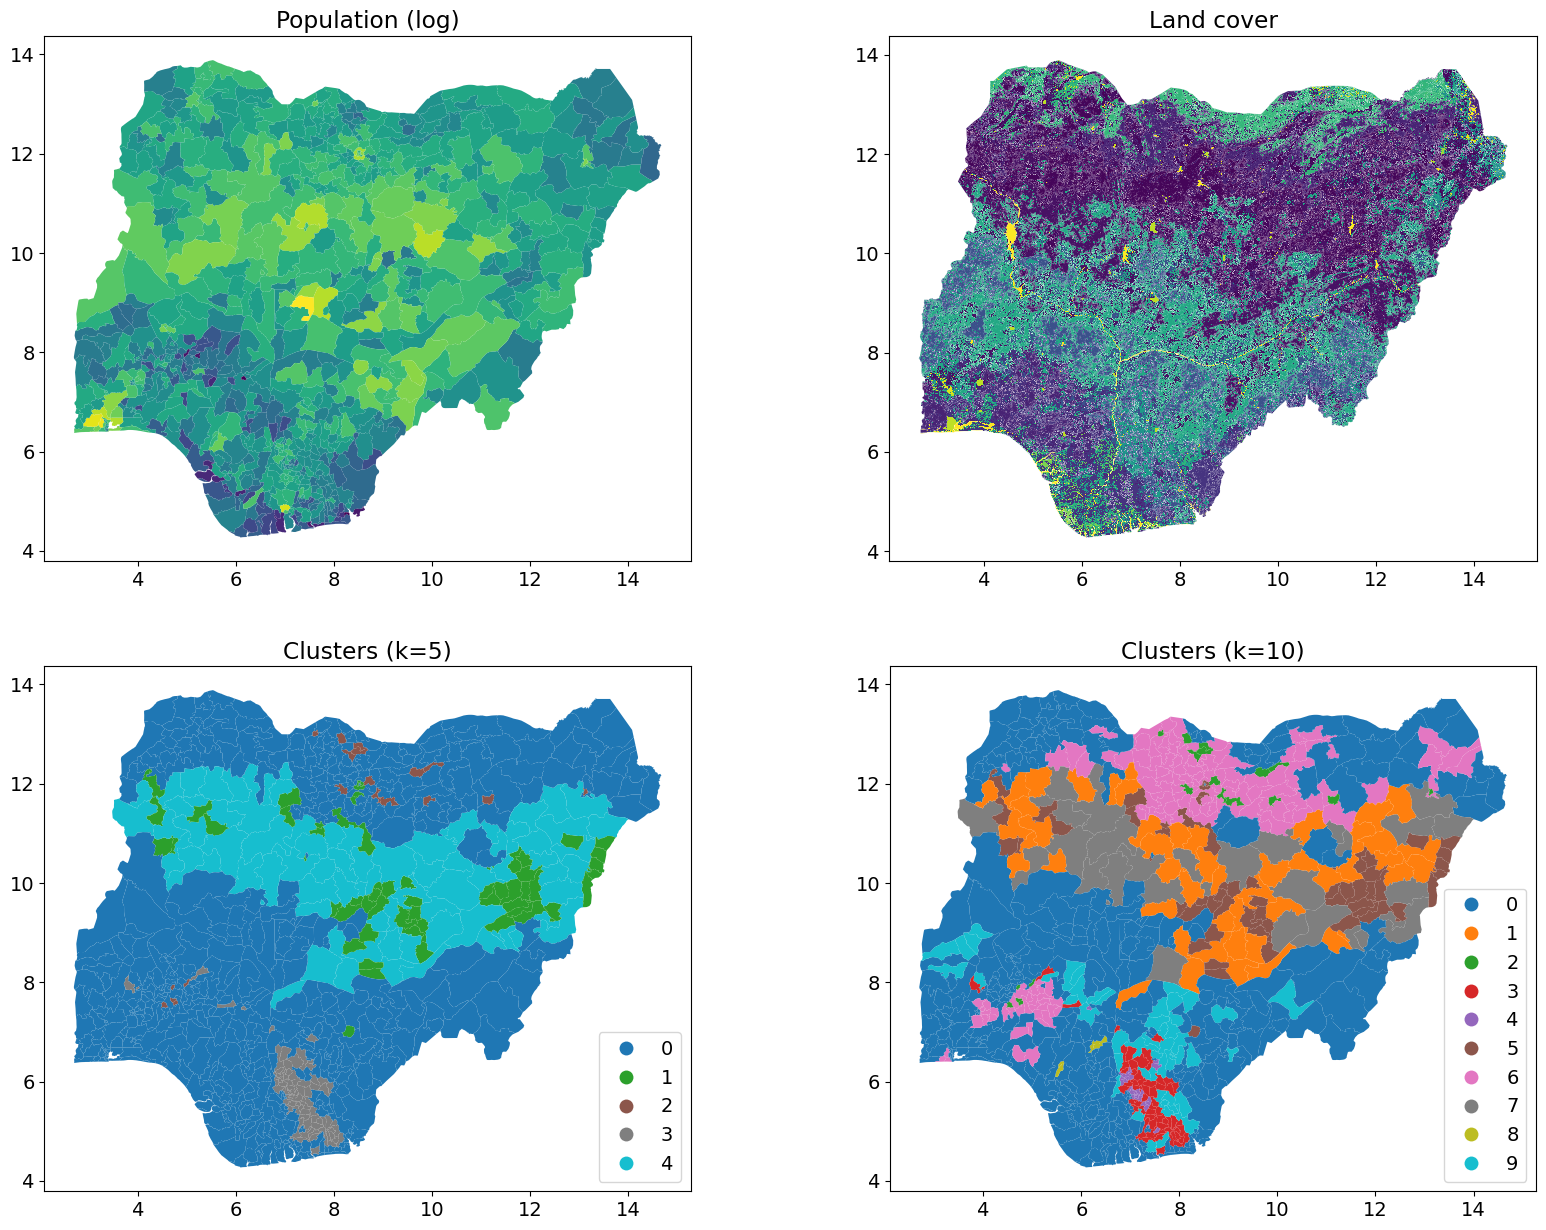

In [66]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))

axs = axs.flatten()

combined_data_gdf.plot(column='log_pop', ax=axs[0], legend=False, legend_kwds = {"ax":axs[0], "shrink":0.5, "location":"bottom"})
axs[0].set_title('Population (log)')

# combined_data_gdf.plot(column='dominant_landcover', ax=axs[1], categorical=True, legend=True, 
#     legend_kwds = {"loc":'lower right', "bbox_to_anchor":(1,-.25), "ncol":2})
# axs[1].set_title('Main land cover type')
landcover_gdf.plot("GRIDCODE", ax=axs[1])
axs[1].set_title("Land cover")

combined_data_gdf.plot(column='cluster_5', ax=axs[2], categorical=True, legend=True, legend_kwds = {"loc":"lower right"})
axs[2].set_title('Clusters (k=5)')

combined_data_gdf.plot(column='cluster_10', ax=axs[3], categorical=True, legend=True, legend_kwds = {"loc":"lower right"})
axs[3].set_title('Clusters (k=10)')

In [43]:
combined_data_gdf.columns

Index(['lga_code', 'id', 'state_code', 'lga_name', 'mean_pop', 'q50', 'q025',
       'q975', 'geometry', 'log_pop', 'lga_area', 'landcover_11',
       'landcover_14', 'landcover_20', 'landcover_30', 'landcover_32',
       'landcover_40', 'landcover_41', 'landcover_60', 'landcover_110',
       'landcover_120', 'landcover_130', 'landcover_134', 'landcover_140',
       'landcover_141', 'landcover_143', 'landcover_150', 'landcover_160',
       'landcover_170', 'landcover_180', 'landcover_190', 'landcover_200',
       'landcover_201', 'landcover_202', 'landcover_210', 'cluster_5',
       'cluster_10'],
      dtype='object')

# SOM - normalized

In [80]:
column_names = ['log_pop', 'landcover_11',
       'landcover_14', 'landcover_20', 'landcover_30', 'landcover_32',
       'landcover_40', 'landcover_41', 'landcover_60', 'landcover_110',
       'landcover_120', 'landcover_130', 'landcover_134', 'landcover_140',
       'landcover_141', 'landcover_143', 'landcover_150', 'landcover_160',
       'landcover_170', 'landcover_180', 'landcover_190', 'landcover_200',
       'landcover_201', 'landcover_202', 'landcover_210']

In [81]:
from sklearn.preprocessing import StandardScaler

#normalize all columns we will be using
scaler = StandardScaler()

for column in column_names:
    combined_data_gdf[column+'_normalized'] = scaler.fit_transform(combined_data_gdf[[column]])

In [82]:
normalized_columns = [column+'_normalized' for column in column_names]

In [83]:
features = combined_data_gdf[normalized_columns].values.astype(np.float64)
features.shape

(774, 25)

In [84]:
x, y = 10, 10

# Initialize the SOM
grid3_som = MiniSom(x, y, input_len=25, sigma=1.0, learning_rate=0.5)

# Train the SOM
grid3_som.train_random(features, 100)

In [85]:
grid3_weights_reshaped = np.reshape(grid3_som_weights, (x*y, 25))

kmeans5 = KMeans(n_clusters=5, random_state=0).fit(grid3_weights_reshaped)
kmeans10 = KMeans(n_clusters=10, random_state=0).fit(grid3_weights_reshaped)

c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_stats\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\soniaji\AppData\Local\anaconda3\envs\spatial_sta

In [86]:
winning_neurons = np.array([grid3_som.winner(feat) for feat in features])

# convert winning_neurons to a 1D array of integers for easy comparison with kmeans.labels_
winning_neurons_1d = np.ravel_multi_index(winning_neurons.T, (x, y))

# create a dictionary mapping from neuron index to cluster
neuron_to_cluster5 = dict(zip(range(x*y), kmeans5.labels_))
neuron_to_cluster10 = dict(zip(range(x*y), kmeans10.labels_))

# map each row to its corresponding cluster
combined_data_gdf['cluster_5'] = [neuron_to_cluster5[i] for i in winning_neurons_1d]
combined_data_gdf['cluster_10'] = [neuron_to_cluster10[i] for i in winning_neurons_1d]

Text(0.5, 1.0, 'Clusters (k=10)')

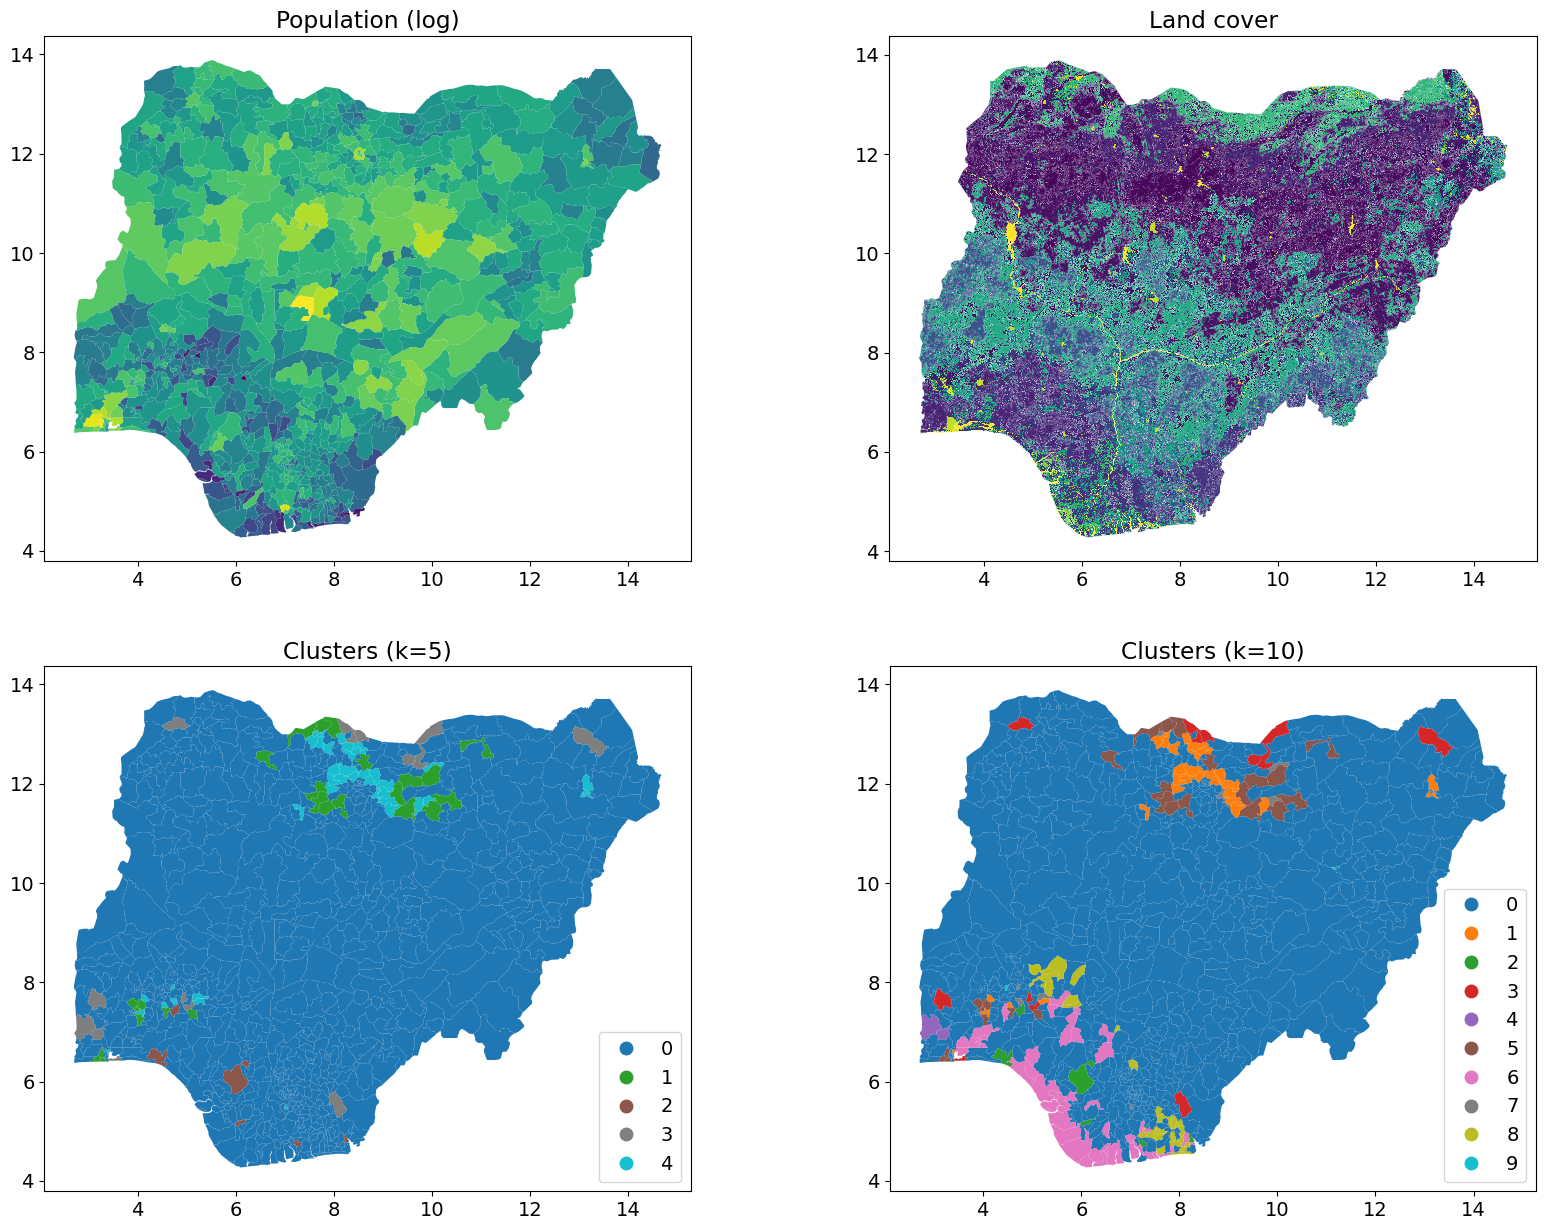

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))

axs = axs.flatten()

combined_data_gdf.plot(column='log_pop', ax=axs[0], legend=False, legend_kwds = {"ax":axs[0], "shrink":0.5, "location":"bottom"})
axs[0].set_title('Population (log)')

# combined_data_gdf.plot(column='dominant_landcover', ax=axs[1], categorical=True, legend=True, 
#     legend_kwds = {"loc":'lower right', "bbox_to_anchor":(1,-.25), "ncol":2})
# axs[1].set_title('Main land cover type')
landcover_gdf.plot("GRIDCODE", ax=axs[1])
axs[1].set_title("Land cover")

combined_data_gdf.plot(column='cluster_5', ax=axs[2], categorical=True, legend=True, legend_kwds = {"loc":"lower right"})
axs[2].set_title('Clusters (k=5)')

combined_data_gdf.plot(column='cluster_10', ax=axs[3], categorical=True, legend=True, legend_kwds = {"loc":"lower right"})
axs[3].set_title('Clusters (k=10)')